<a href="https://colab.research.google.com/github/RANGAM-AKHILA/TESS/blob/main/speech_only_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

FEATURE_ROOT = "/content/drive/MyDrive/Colab Notebooks/hubert_features"

BATCH_SIZE = 2
EPOCHS = 5
LR = 2e-5


Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
x = torch.load("/content/drive/MyDrive/Colab Notebooks/hubert_features/sad/OAF_bar_sad.pt")

print(x.shape)
print("Min:", x.min().item())
print("Max:", x.max().item())
print("Mean:", x.mean().item())
print("Non-zero count:", (x != 0).sum().item())


torch.Size([124, 768])
Min: -8.344808578491211
Max: 6.30464506149292
Mean: 0.004650633316487074
Non-zero count: 95232


In [ ]:
class HubertFeatureDataset(Dataset):
    def __init__(self, root_dir):
        self.samples = []

        for emotion in os.listdir(root_dir):
            emotion_path = os.path.join(root_dir, emotion)
            for file in os.listdir(emotion_path):
                if file.endswith(".pt"):
                    self.samples.append(
                        (os.path.join(emotion_path, file), emotion)
                    )

        print("Total samples:", len(self.samples))
        print("Class distribution:", Counter([e for _, e in self.samples]))

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit([e for _, e in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, emotion = self.samples[idx]
        features = torch.load(path)            # (T, 768)
        label = self.label_encoder.transform([emotion])[0]
        return features, torch.tensor(label)


In [ ]:
def collate_fn(batch):
    features = [b[0] for b in batch]
    labels = torch.tensor([b[1] for b in batch])

    features = pad_sequence(
        features, batch_first=True
    )  # (B, T, 768)

    return features, labels


In [ ]:
dataset = HubertFeatureDataset(FEATURE_ROOT)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE,
    shuffle=True, collate_fn=collate_fn
)

val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_ds, batch_size=BATCH_SIZE,
    shuffle=False, collate_fn=collate_fn
)

NUM_CLASSES = len(dataset.label_encoder.classes_)
print("Classes:", dataset.label_encoder.classes_)


Total samples: 2800
Class distribution: Counter({'neutral': 400, 'happy': 400, 'sad': 400, 'pleasant_surprise': 400, 'fear': 400, 'disgust': 400, 'angry': 400})
Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'pleasant_surprise' 'sad']


In [ ]:
import torch
import torch.nn as nn

class CNN_LSTM_EmotionModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Temporal Modelling (CNN)
        self.cnn = nn.Sequential(
            nn.Conv1d(
                in_channels=768,
                out_channels=256,
                kernel_size=5,
                padding=2
            ),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # Contextual Modelling (BiLSTM)
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Classifier
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x, return_features=False):
        """
        x: (B, T, 768)
        """

        # ================= Temporal Block =================
        x = x.transpose(1, 2)         # (B, 768, T)
        temporal_out = self.cnn(x)    # (B, 256, T')

        x = temporal_out.transpose(1, 2)  # (B, T', 256)

        # ================= Contextual Block =================
        _, (h, _) = self.lstm(x)

        contextual_vec = torch.cat(
            (h[-2], h[-1]),
            dim=1
        )  # (B, 256)


        fusion_vec = contextual_vec

        logits = self.fc(fusion_vec)

        if return_features:
            return logits, temporal_out.transpose(1, 2), contextual_vec, fusion_vec

        return logits


In [ ]:
model = CNN_LSTM_EmotionModel(NUM_CLASSES).to(DEVICE)

criterion = nn.CrossEntropyLoss()   # Softmax handled internally
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [ ]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        features = features.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/5: 100%|██████████| 980/980 [22:42<00:00,  1.39s/it]


Epoch 1 Train Loss: 1.2569


Epoch 2/5: 100%|██████████| 980/980 [00:14<00:00, 68.38it/s]


Epoch 2 Train Loss: 0.1829


Epoch 3/5: 100%|██████████| 980/980 [00:13<00:00, 70.02it/s]


Epoch 3 Train Loss: 0.0529


Epoch 4/5: 100%|██████████| 980/980 [00:13<00:00, 70.27it/s]


Epoch 4 Train Loss: 0.0201


Epoch 5/5: 100%|██████████| 980/980 [00:13<00:00, 70.52it/s]

Epoch 5 Train Loss: 0.0088


In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in val_loader:
        preds = model(features.to(DEVICE)).argmax(dim=1).cpu()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

print("\n📊 VALIDATION RESULTS\n")
print(classification_report(
    y_true, y_pred,
    target_names=dataset.label_encoder.classes_
))



📊 VALIDATION RESULTS

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        70
          disgust       1.00      1.00      1.00        55
             fear       1.00      1.00      1.00        51
            happy       1.00      1.00      1.00        63
          neutral       1.00      1.00      1.00        54
pleasant_surprise       1.00      1.00      1.00        72
              sad       1.00      1.00      1.00        55

         accuracy                           1.00       420
        macro avg       1.00      1.00      1.00       420
     weighted avg       1.00      1.00      1.00       420



In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        preds = model(features.to(DEVICE)).argmax(dim=1).cpu()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

print("\n📊 TEST RESULTS (FINAL)\n")
print(classification_report(
    y_true, y_pred,
    target_names=dataset.label_encoder.classes_
))



📊 TEST RESULTS (FINAL)

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        59
          disgust       1.00      1.00      1.00        74
             fear       1.00      1.00      1.00        60
            happy       1.00      0.98      0.99        66
          neutral       1.00      1.00      1.00        50
pleasant_surprise       0.98      1.00      0.99        52
              sad       1.00      1.00      1.00        60

         accuracy                           1.00       421
        macro avg       1.00      1.00      1.00       421
     weighted avg       1.00      1.00      1.00       421



In [ ]:
import os
import torch.nn.functional as F

def infer_10_files(model, folder_path, class_names):
    model.eval()

    files = [f for f in os.listdir(folder_path) if f.endswith(".pt")]
    files = files[:10]   # take first 10

    print("\n🔎 INFERENCE ON 10 FILES\n")

    for file in files:
        file_path = os.path.join(folder_path, file)

        features = torch.load(file_path).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits = model(features)
            probs = F.softmax(logits, dim=1)
            pred = probs.argmax(dim=1).item()

        print(f"File       : {file}")
        print(f"Prediction : {class_names[pred]}")
        print(f"Confidence : {probs[0][pred].item():.4f}")
        print("-" * 45)


In [ ]:
CLASS_NAMES = [
    "angry",
    "disgust",
    "fear",
    "happy",
    "neutral",
    "pleasant_surprise",
    "sad"
]


In [ ]:
infer_10_files(
    model,
    "/content/drive/MyDrive/Colab Notebooks/hubert_features/happy",
    CLASS_NAMES
)



🔎 INFERENCE ON 10 FILES

File       : YAF_jail_happy.pt
Prediction : happy
Confidence : 0.9842
---------------------------------------------
File       : YAF_pearl_happy.pt
Prediction : happy
Confidence : 0.9882
---------------------------------------------
File       : YAF_pike_happy.pt
Prediction : happy
Confidence : 0.9950
---------------------------------------------
File       : YAF_raise_happy.pt
Prediction : happy
Confidence : 0.9897
---------------------------------------------
File       : YAF_shout_happy.pt
Prediction : happy
Confidence : 0.9931
---------------------------------------------
File       : YAF_merge_happy.pt
Prediction : happy
Confidence : 0.9923
---------------------------------------------
File       : YAF_laud_happy.pt
Prediction : happy
Confidence : 0.9924
---------------------------------------------
File       : YAF_hire_happy.pt
Prediction : happy
Confidence : 0.9884
---------------------------------------------
File       : YAF_lore_happy.pt
Prediction 

In [ ]:
infer_10_files(
    model,
    "/content/drive/MyDrive/Colab Notebooks/hubert_features/sad",
    CLASS_NAMES
)



🔎 INFERENCE ON 10 FILES

File       : OAF_germ_sad.pt
Prediction : sad
Confidence : 0.9969
---------------------------------------------
File       : OAF_thumb_sad.pt
Prediction : sad
Confidence : 0.9925
---------------------------------------------
File       : OAF_rag_sad.pt
Prediction : sad
Confidence : 0.9964
---------------------------------------------
File       : OAF_mood_sad.pt
Prediction : sad
Confidence : 0.9900
---------------------------------------------
File       : OAF_nice_sad.pt
Prediction : sad
Confidence : 0.9971
---------------------------------------------
File       : OAF_perch_sad.pt
Prediction : sad
Confidence : 0.9969
---------------------------------------------
File       : OAF_boat_sad.pt
Prediction : sad
Confidence : 0.9942
---------------------------------------------
File       : OAF_mop_sad.pt
Prediction : sad
Confidence : 0.9967
---------------------------------------------
File       : OAF_thought_sad.pt
Prediction : sad
Confidence : 0.9933
---------

In [ ]:
infer_10_files(
    model,
    "/content/drive/MyDrive/Colab Notebooks/hubert_features/disgust",
    CLASS_NAMES
)



🔎 INFERENCE ON 10 FILES

File       : OAF_good_disgust.pt
Prediction : disgust
Confidence : 0.9926
---------------------------------------------
File       : OAF_learn_disgust.pt
Prediction : disgust
Confidence : 0.9930
---------------------------------------------
File       : OAF_pike_disgust.pt
Prediction : disgust
Confidence : 0.9845
---------------------------------------------
File       : OAF_rag_disgust.pt
Prediction : disgust
Confidence : 0.9890
---------------------------------------------
File       : OAF_kick_disgust.pt
Prediction : disgust
Confidence : 0.9937
---------------------------------------------
File       : OAF_shawl_disgust.pt
Prediction : disgust
Confidence : 0.9760
---------------------------------------------
File       : OAF_chat_disgust.pt
Prediction : disgust
Confidence : 0.9965
---------------------------------------------
File       : OAF_mess_disgust.pt
Prediction : disgust
Confidence : 0.9952
---------------------------------------------
File       : 

In [ ]:
infer_10_files(
    model,
    "/content/drive/MyDrive/Colab Notebooks/hubert_features/fear",
    CLASS_NAMES
)



🔎 INFERENCE ON 10 FILES

File       : YAF_home_fear.pt
Prediction : fear
Confidence : 0.9744
---------------------------------------------
File       : YAF_youth_fear.pt
Prediction : fear
Confidence : 0.9785
---------------------------------------------
File       : YAF_near_fear.pt
Prediction : fear
Confidence : 0.9875
---------------------------------------------
File       : YAF_search_fear.pt
Prediction : fear
Confidence : 0.9897
---------------------------------------------
File       : YAF_pick_fear.pt
Prediction : fear
Confidence : 0.9904
---------------------------------------------
File       : YAF_dodge_fear.pt
Prediction : fear
Confidence : 0.9912
---------------------------------------------
File       : YAF_void_fear.pt
Prediction : fear
Confidence : 0.9929
---------------------------------------------
File       : YAF_sheep_fear.pt
Prediction : fear
Confidence : 0.9770
---------------------------------------------
File       : YAF_pain_fear.pt
Prediction : fear
Confidenc

In [ ]:
infer_10_files(
    model,
    "/content/drive/MyDrive/Colab Notebooks/hubert_features/neutral",
    CLASS_NAMES
)



🔎 INFERENCE ON 10 FILES

File       : OAF_soup_neutral.pt
Prediction : neutral
Confidence : 0.9910
---------------------------------------------
File       : OAF_dime_neutral.pt
Prediction : neutral
Confidence : 0.9968
---------------------------------------------
File       : OAF_door_neutral.pt
Prediction : neutral
Confidence : 0.9926
---------------------------------------------
File       : OAF_gun_neutral.pt
Prediction : neutral
Confidence : 0.9964
---------------------------------------------
File       : OAF_goose_neutral.pt
Prediction : neutral
Confidence : 0.9947
---------------------------------------------
File       : OAF_numb_neutral.pt
Prediction : neutral
Confidence : 0.9882
---------------------------------------------
File       : OAF_home_neutral.pt
Prediction : neutral
Confidence : 0.9907
---------------------------------------------
File       : OA_bite_neutral.pt
Prediction : neutral
Confidence : 0.9968
---------------------------------------------
File       : OA

In [ ]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in test_loader:
        preds = model(features.to(DEVICE)).argmax(dim=1).cpu()
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

print("\n📊 TEST RESULTS (FINAL)\n")
print(classification_report(
    y_true, y_pred,
    target_names=dataset.label_encoder.classes_
))



📊 TEST RESULTS (FINAL)

                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        57
          disgust       1.00      1.00      1.00        66
             fear       1.00      1.00      1.00        62
            happy       0.98      1.00      0.99        56
          neutral       1.00      1.00      1.00        60
pleasant_surprise       1.00      0.99      0.99        71
              sad       1.00      1.00      1.00        49

         accuracy                           1.00       421
        macro avg       1.00      1.00      1.00       421
     weighted avg       1.00      1.00      1.00       421



In [ ]:
torch.save(
    {
        "model_state": model.state_dict(),
        "label_encoder": dataset.label_encoder
    },
    "hubert_cnn_lstm_emotion.pth"
)

print("✅ Model saved successfully")


In [ ]:
import numpy as np

model.eval()

temporal_feats = []
contextual_feats = []
fusion_feats = []
labels_all = []

with torch.no_grad():
    for features, labels in test_loader:

        features = features.to(DEVICE)

        logits, temp, ctx, fus = model(
            features,
            return_features=True
        )

        # Temporal → mean pooling over time
        temp = temp.mean(dim=1).cpu().numpy()

        ctx = ctx.cpu().numpy()
        fus = fus.cpu().numpy()

        temporal_feats.append(temp)
        contextual_feats.append(ctx)
        fusion_feats.append(fus)

        labels_all.extend(labels.numpy())

temporal_feats = np.concatenate(temporal_feats)
contextual_feats = np.concatenate(contextual_feats)
fusion_feats = np.concatenate(fusion_feats)
labels_all = np.array(labels_all)


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels, title, class_names):

    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(7,6))

    for i, name in enumerate(class_names):
        idx = labels == i
        plt.scatter(
            reduced[idx, 0],
            reduced[idx, 1],
            label=name,
            alpha=0.7
        )

    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


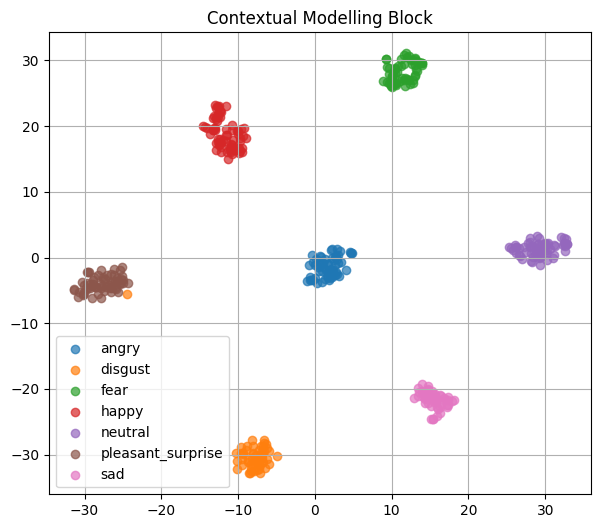

In [ ]:
class_names = dataset.label_encoder.classes_

plot_tsne(contextual_feats, labels_all,
          "Contextual Modelling Block", class_names)

